# DistilBert

### Import necessary packages

In [1]:
import numpy as np
import mlflow
import logging 
import torch 
import config 
import os 
from mlflow.sklearn import save_model
from transformers import AutoModelForSequenceClassification, AutoConfig

# import mlflow.pytorch
os.environ["TOKENIZERS_PARALLELISM"] = "false"  # This tells Hugging Face: “Don’t use parallel tokenization — avoid possible deadlocks.”

/Users/maren/Library/CloudStorage/OneDrive-Persönlich/Dokumente/neue_fische/Capstone Project/Capstone_project/backend/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from basic_functions import(
    get_encode_tokenize_data,
    createTrainer,
    get_eval_metrics,
    get_error_analysis,
    print_error_df
)

### Setup

In [3]:
MODEL_NAME = "distilbert-base-uncased" # pulls the general-purpose DistilBERT model
TRACKING_URI = open("../.mlflow_uri").read().strip()
EXPERIMENT_NAME = config.EXPERIMENT_NAME

logging.basicConfig(format="%(asctime)s: %(message)s") # Configure logging format to show timestamp before every message

logger = logging.getLogger()
logger.setLevel(logging.INFO) # Only show logs that are INFO or more important (e.g., WARNING, ERROR) — but ignore DEBUG.

In [4]:
# DATA_PATH = "../data/data_small.csv"
DATA_PATH = "../data/data_binary_imbalanced.csv" # uncomment this when checking that everything is just running properly. 
MODEL_PATH = "distilbert-base-uncased"
MODEL_TRAINING_PATH ="distilbert-base-uncased"
OUTPUT_DIR = "../models/distilbert_binary_imbalanced/trainer_output"
SAVE_PATH = "../models/distilbert_binary_imbalanced/pytorch_model"

### Get data

In [5]:
# use "binary" for binary classification and "multiclass" for multiclass classification
train_dataset, test_dataset, encoded_train_dataset, encoded_test_dataset, le = get_encode_tokenize_data("binary", DATA_PATH, MODEL_PATH)

2025-04-15 12:37:34,213: Loading data...
2025-04-15 12:37:34,229: Train test split, test-size 0.3
2025-04-15 12:37:34,233: Create encoded dataframes
2025-04-15 12:37:34,234: Encode the label column
2025-04-15 12:37:34,235: Tokenize
2025-04-15 12:37:34,235: create tokenizer & load model
2025-04-15 12:37:35,463: create tokenizer & load model
2025-04-15 12:37:36,041: Create TextDatasets (train & test)


In [ ]:
y_train = encoded_train_dataset['two_class_target']

### Model Initialization

In [7]:
learning_rate= 3e-5
weight_decay= 0.01
num_train_epochs= 4
evaluation_strategy= 'epoch'
class_weight=False
dropout= 0.3


params = {
      "learning_rate": learning_rate,
      "weight_decay": weight_decay,
      "num_train_epochs": num_train_epochs,
      "evaluation_strategy": evaluation_strategy,
      "class_weight":class_weight,
      "dropout": dropout,
      "dataset": DATA_PATH
  }


# setting the MLFlow connection and experiment
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)


mlflow.start_run()
run = mlflow.active_run()
print("Active run_id: {}".format(run.info.run_id))

mlflow.set_tag("model_name", MODEL_NAME)
mlflow.set_tag("mlflow.runName", "Distilbert Binary Imbalanced")
mlflow.log_params(params)

Active run_id: 80cc0bef5cf24f97b2c338f2f9cbe005


In [8]:
num_classes = len(np.unique(y_train))
num_classes

2

In [9]:
# Load config and set dropout
config = AutoConfig.from_pretrained(MODEL_TRAINING_PATH)
config.num_labels = num_classes # Set number of labels for classification
config.dropout = dropout # Set dropout, default is 0.1

# Load model with updated config
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_TRAINING_PATH,
    config=config  # Pass modified config
)

# model.gradient_checkpointing_enable() 

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
trainer = createTrainer(
    model= model, 
    train_dataset = train_dataset,
    test_dataset = test_dataset,
    output_dir= OUTPUT_DIR, 
    y_train=y_train, 
    class_weight=class_weight, 
    epochs=num_train_epochs, 
    learning_rate=learning_rate, 
    weight_decay = weight_decay, 
    train_batch_size=4, 
    eval_batch_size=8 )

2025-04-15 12:37:36,599: defining training arguments
2025-04-15 12:37:36,632: get normal trainer


### Execute Training

In [11]:
torch.mps.empty_cache()  # Clears unused GPU memory

In [12]:
# disable upper limit for memory
os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"

# Allows up to 100% of available memory
torch.mps.set_per_process_memory_fraction(1.0)  

In [13]:
logger.info('training is running')
trainer.train()

2025-04-15 12:37:37,244: training is running


Epoch,Training Loss,Validation Loss,Accuracy
1,0.425500,0.579329,0.871961
2,0.304200,0.522101,0.871421
3,0.306800,0.590997,0.864398
4,0.177900,0.674969,0.870881


TrainOutput(global_step=4320, training_loss=0.33073605826055563, metrics={'train_runtime': 1606.5128, 'train_samples_per_second': 10.749, 'train_steps_per_second': 2.689, 'total_flos': 2287447039991808.0, 'train_loss': 0.33073605826055563, 'epoch': 4.0})

### Evaluation


In [14]:
def log_metrics(cr, brier, split):
    mlflow.log_metric(f"{split}_brier", brier)

    for key, value in cr.items():
        if (key == "accuracy"):
                # print(f"{split}_{key}", round(value,2))
                mlflow.log_metric(f"{split}_{key}", value)
        else:
            for metric in value:
                mlflow.log_metric(f"{split}_{key}_{metric}", value.get(metric))
                # print(f"{split}_{key}_{metric}", round(value.get(metric),2))

    

2025-04-15 13:04:23,982: predict on test_dataset


2025-04-15 13:05:05,806: get evaluation metrics
2025-04-15 13:05:05,808: classification_report
2025-04-15 13:05:05,825: confusion_matrix
2025-04-15 13:05:05,828: heatmap


              precision    recall  f1-score   support

     fallacy       0.63      0.50      0.56       300
        none       0.91      0.94      0.92      1551

    accuracy                           0.87      1851
   macro avg       0.77      0.72      0.74      1851
weighted avg       0.86      0.87      0.87      1851



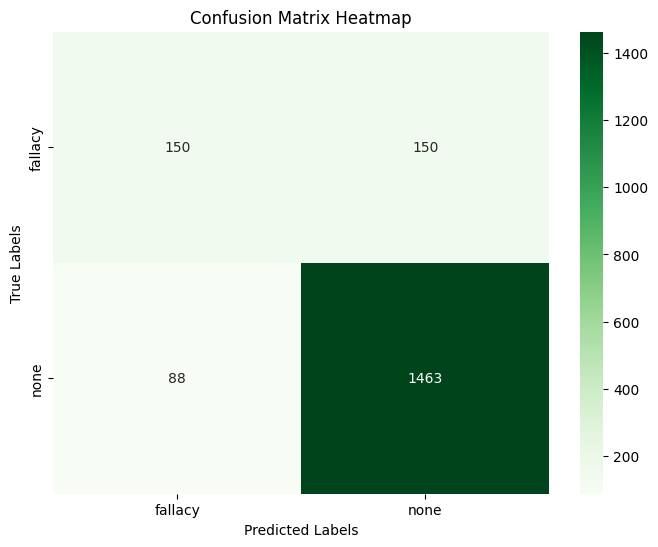

2025-04-15 13:05:06,065: brier score


Multiclass Brier score: 0.9681245934321748


In [15]:
logger.info('predict on test_dataset')
test_output = trainer.predict(test_dataset)

classification_report, brier = get_eval_metrics(test_output, le)
log_metrics(classification_report, brier, "test")


2025-04-15 13:05:06,287: predict on train_dataset


2025-04-15 13:06:49,328: get evaluation metrics
2025-04-15 13:06:49,330: classification_report
2025-04-15 13:06:49,339: confusion_matrix
2025-04-15 13:06:49,341: heatmap


              precision    recall  f1-score   support

     fallacy       0.90      0.72      0.80       700
        none       0.95      0.98      0.97      3617

    accuracy                           0.94      4317
   macro avg       0.92      0.85      0.88      4317
weighted avg       0.94      0.94      0.94      4317



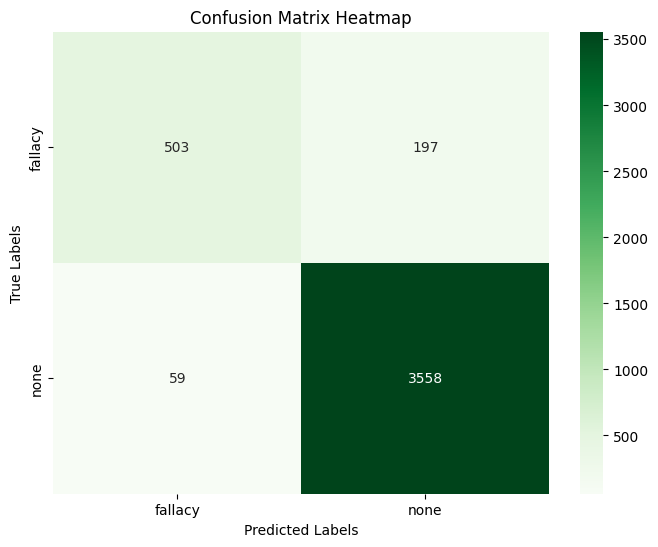

2025-04-15 13:06:49,453: brier score


Multiclass Brier score: 0.9778717964056854


In [16]:
logger.info('predict on train_dataset')
train_output = trainer.predict(train_dataset)

classification_report, brier= get_eval_metrics(train_output, le)
log_metrics(classification_report, brier, "train")


In [17]:
mlflow.end_run()

🏃 View run Distilbert Binary Imbalanced at: http://127.0.0.1:5001/#/experiments/823412171152425451/runs/80cc0bef5cf24f97b2c338f2f9cbe005
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/823412171152425451


### Save model

In [18]:
#save with pytorch
mlflow.pytorch.save_model(model, path=SAVE_PATH)

### Error Analysis

In [19]:
df_error_test = get_error_analysis(test_output, encoded_test_dataset)

In [20]:
# get text, which is predicted false
print_error_df(df_error_test)

Example 0:
Text: It s an amazing fact that Indigenous people protect 80 percent of the world s biodiversity shockingly their population is only 5 population share We clearly aren t doing enough if they are such a small population and doing almost ALL the work To address this unfair balance I think we have a couple of solutions here First we could enlist people from outside the Indigenous community and have them come to these remote areas and do the protecting themselves That way the Indigenous community can train them properly and make sure they are doing the job effectively The other option is to build an army of environmentalist robots their job would be to constantly monitor the biodiversity on the planet and make sure it is never damaged Clearly this could be an expensive project but it seems it could be massively beneficial and almost all workload would be off of human s hands Do both of these options have problems Yes I can see the Indigenous population not wanting all these outs

In [21]:
# get dataset, with most false predicted values
df_counts = df_error_test[['dataset', 'true_label', 'pred_label']].groupby(['dataset', 'true_label']).value_counts().reset_index()
df_counts.sort_values('count', ascending=False)

,dataset,true_label,pred_label,count
2,3,0,1,90
5,4,1,0,31
3,3,1,0,30
4,4,0,1,20
10,8,1,0,18
0,1,0,1,11
1,2,0,1,10
9,8,0,1,10
11,9,0,1,8
6,5,1,0,7
